---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the [Jupyter Notebook FAQ](https://www.coursera.org/learn/python-social-network-analysis/resources/yPcBs) course resource._

---

# Assignment 4

In [45]:
import networkx as nx
import pandas as pd
import numpy as np
import pickle

---

## Part 1 - Random Graph Identification

For the first part of this assignment you will analyze randomly generated graphs and determine which algorithm created them.

In [46]:
P1_Graphs = pickle.load(open('A4_graphs','rb'))
P1_Graphs

<br>
`P1_Graphs` is a list containing 5 networkx graphs. Each of these graphs were generated by one of three possible algorithms:
* Preferential Attachment (`'PA'`)
* Small World with low probability of rewiring (`'SW_L'`)
* Small World with high probability of rewiring (`'SW_H'`)

Anaylze each of the 5 graphs and determine which of the three algorithms generated the graph.

*The `graph_identification` function should return a list of length 5 where each element in the list is either `'PA'`, `'SW_L'`, or `'SW_H'`.*

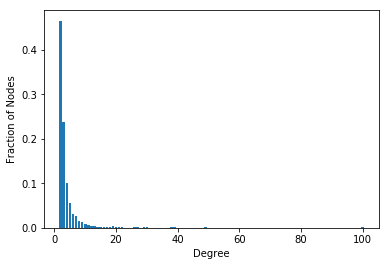

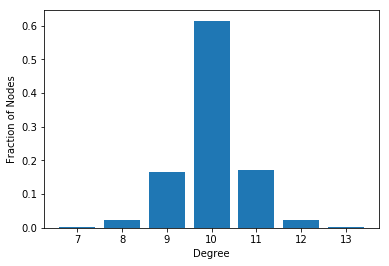

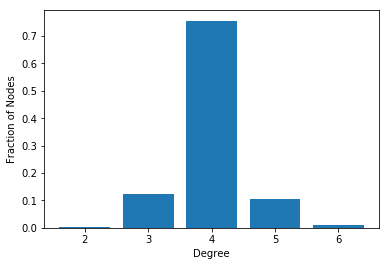

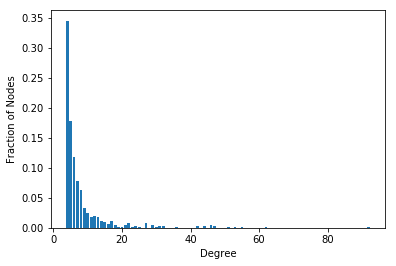

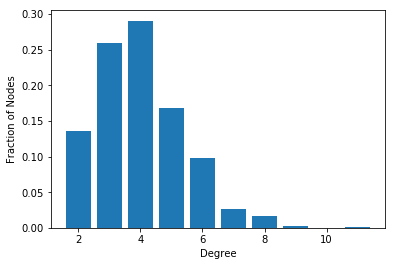

In [60]:
def graph_degree_plt():
    import matplotlib.pyplot as plt
    for graph in P1_Graphs:
        degrees = graph.degree()
        degree_values = sorted(set(degrees.values()))
        histogram = [list(degrees.values()).count(i) / nx.number_of_nodes(graph) 
                     for i in degree_values]
        
        plt.bar(degree_values, histogram)
        plt.xlabel('Degree')
        plt.ylabel('Fraction of Nodes')
        plt.show()
graph_degree_plt()

It can be observed that the degree distribution of P1_Graphs[0], P1_Graphs[3] follows power law,

which suggests that they are generated from PA model.

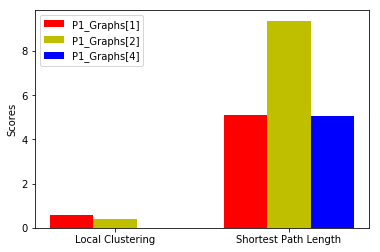

In [59]:
def graph_LC_SPL_plt():
    import matplotlib.pyplot as plt
    
    g1 = P1_Graphs[1]
    g2 = P1_Graphs[2]
    g4 = P1_Graphs[4]
    
    N = 2
    g1_stats = nx.average_clustering(g1), nx.average_shortest_path_length(g1)
    g2_stats = nx.average_clustering(g2), nx.average_shortest_path_length(g2)
    g4_stats = nx.average_clustering(g4), nx.average_shortest_path_length(g4)
    
    ind = np.arange(N)  # the x locations for the groups
    width = 0.25       # the width of the bars
    
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, g1_stats, width, color='r')
    rects2 = ax.bar(ind + width, g2_stats, width, color='y')
    rects4 = ax.bar(ind + 2 * width, g4_stats, width, color='b')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Scores')
    ax.set_xticks(ind + width)
    ax.set_xticklabels(('Local Clustering', 'Shortest Path Length'))

    ax.legend((rects1[0], rects2[0], rects4[0]), ('P1_Graphs[1]', 'P1_Graphs[2]', 'P1_Graphs[4]'))
    plt.show()
graph_LC_SPL_plt()

P1_Graphs[4] has very small LC but relatively large SPL, and its degree distribution is tilted from a normal distribution, which suggests it is disturbed by high rewiring probability.

In [26]:
def graph_identification(): 
    return ['PA', 'SW_L', 'SW_L', 'PA', 'SW_H']

---

## Part 2 - Company Emails

For the second part of this assignment you will be workking with a company's email network where each node corresponds to a person at the company, and each edge indicates that at least one email has been sent between two people.

The network also contains the node attributes `Department` and `ManagmentSalary`.

`Department` indicates the department in the company which the person belongs to, and `ManagmentSalary` indicates whether that person is receiving a managment position salary.

In [6]:
G = nx.read_gpickle('email_prediction.txt')

print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16706
Average degree:  33.2458


### Part 2A - Salary Prediction

Using network `G`, identify the people in the network with missing values for the node attribute `ManagementSalary` and predict whether or not these individuals are receiving a managment position salary.

To accomplish this, you will need to create a matrix of node features using networkx, train a sklearn classifier on nodes that have `ManagementSalary` data, and predict a probability of the node receiving a managment salary for nodes where `ManagementSalary` is missing.



Your predictions will need to be given as the probability that the corresponding employee is receiving a managment position salary.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will receive full points.

Using your trained classifier, return a series of length 252 with the data being the probability of receiving managment salary, and the index being the node id.

    Example:
    
        1       1.0
        2       0.0
        5       0.8
        8       1.0
            ...
        996     0.7
        1000    0.5
        1001    0.0
        Length: 252, dtype: float64

In [23]:
def salary_predictions():
    from sklearn.ensemble import RandomForestClassifier
    
    idx = [G.nodes(data=True)[i][0] for i in range(nx.number_of_nodes(G))]

    dept = [G.nodes(data=True)[i][1]['Department'] for i in range(nx.number_of_nodes(G))]

    salary = [G.nodes(data=True)[i][1]['ManagementSalary'] for i in range(nx.number_of_nodes(G))]

    df = pd.DataFrame(data={'Department': dept, 'ManagementSalary': salary}, index=idx)

    df['DegreeCentrality'] = nx.degree_centrality(G).values()

    df['ClosenessCentrality'] = nx.closeness_centrality(G).values()

    df['BetweennessCentrality'] = nx.betweenness_centrality(G, normalized=True, endpoints=False).values()

    df['PageRank'] = nx.pagerank(G, alpha=0.8).values()

    df['Hub'], df['Authority'] = nx.hits(G)[0].values(), nx.hits(G)[1].values()
    
    X_train = df.dropna().drop('ManagementSalary', axis=1)

    y_train = df['ManagementSalary'].iloc[X_train.index]

    X_test = df[~df.index.isin(X_train.index)].drop('ManagementSalary', axis=1)
    
    clf = RandomForestClassifier(n_estimators = 400).fit(X_train, y_train)
    
    y_test = [proba[1] for proba in clf.predict_proba(X_test)]
    
    submit = pd.Series(data = y_test, index = X_test.index)
    return submit

salary_predictions()

1       0.0750
2       0.9325
5       0.9925
8       0.0725
14      0.0800
18      0.1600
27      0.3025
30      0.2250
31      0.5700
34      0.0625
37      0.0400
40      0.1325
45      0.0675
54      0.3875
55      0.3225
60      0.2925
62      1.0000
65      0.9550
77      0.0525
79      0.2675
97      0.0075
101     0.0025
103     0.1375
108     0.2125
113     0.0825
122     0.0225
141     0.3375
142     0.9950
144     0.0425
145     0.1100
         ...  
913     0.0000
914     0.0200
915     0.0000
918     0.0150
923     0.0025
926     0.0000
931     0.0025
934     0.0050
939     0.0025
944     0.0000
945     0.0000
947     0.2575
950     0.3150
951     0.0000
953     0.0025
959     0.0000
962     0.0000
963     0.2550
968     0.0000
969     0.0000
974     0.0000
984     0.0050
987     0.0000
989     0.0000
991     0.0025
992     0.0000
994     0.0000
996     0.0000
1000    0.0150
1001    0.0000
Length: 252, dtype: float64

### Part 2B - New Connections Prediction

For the last part of this assignment, you will predict future connections between employees of the network. The future connections information has been loaded into the variable `future_connections`. The index is a tuple indicating a pair of nodes that currently do not have a connection, and the `Future Connection` column indicates if an edge between those two nodes will exist in the future, where a value of 1.0 indicates a future connection.

In [9]:
future_connections = pd.read_csv('Future_Connections.csv', index_col=0, converters={0: eval})
future_connections.head(10)

,Future Connection
"(6, 840)",0.0
"(4, 197)",0.0
"(620, 979)",0.0
"(519, 872)",0.0
"(382, 423)",0.0
"(97, 226)",1.0
"(349, 905)",0.0
"(429, 860)",0.0
"(309, 989)",0.0
"(468, 880)",0.0


Using network `G` and `future_connections`, identify the edges in `future_connections` with missing values and predict whether or not these edges will have a future connection.

To accomplish this, you will need to create a matrix of features for the edges found in `future_connections` using networkx, train a sklearn classifier on those edges in `future_connections` that have `Future Connection` data, and predict a probability of the edge being a future connection for those edges in `future_connections` where `Future Connection` is missing.



Your predictions will need to be given as the probability of the corresponding edge being a future connection.

The evaluation metric for this assignment is the Area Under the ROC Curve (AUC).

Your grade will be based on the AUC score computed for your classifier. A model which with an AUC of 0.75 or higher will receive full points.

Using your trained classifier, return a series of length 122112 with the data being the probability of the edge being a future connection, and the index being the edge as represented by a tuple of nodes.

    Example:
    
        (107, 348)    0.35
        (542, 751)    0.40
        (20, 426)     0.55
        (50, 989)     0.35
                  ...
        (939, 940)    0.15
        (555, 905)    0.35
        (75, 101)     0.65
        Length: 122112, dtype: float64

In [24]:
def new_connections_predictions():
    from sklearn.ensemble import RandomForestClassifier

    future_connections['Common Neighbors'] = list(map(
    lambda idx: len(list(nx.common_neighbors(G, idx[0], idx[1]))), future_connections.index))

    future_connections['Jaccard Coefficient'] = list(map(
        lambda idx: (list(nx.jaccard_coefficient(G, [(idx[0], idx[1])]))[-1][-1]), future_connections.index))

    future_connections['Resource Allocation'] = list(map(
        lambda idx: (list(nx.resource_allocation_index(G, [(idx[0], idx[1])]))[-1][-1]), future_connections.index))

    future_connections['Prefertial Attachment'] = list(map(
        lambda idx: (list(nx.preferential_attachment(G, [(idx[0], idx[1])]))[-1][-1]), future_connections.index))

    future_connections['Adamic-Adar'] = list(map(
        lambda idx: (list(nx.adamic_adar_index(G, [(idx[0], idx[1])]))[-1][-1]), future_connections.index))
    
    X_train = future_connections.dropna().drop('Future Connection', axis=1)

    y_train = future_connections['Future Connection'].ix[X_train.index]

    X_test = future_connections[~future_connections.index.isin(X_train.index)].drop('Future Connection', axis=1)
    
    clf = RandomForestClassifier(n_estimators = 50).fit(X_train, y_train)
        
    y_test = [proba[1] for proba in clf.predict_proba(X_test)]
    
    submit = pd.Series(data = y_test, index = X_test.index)
    return submit

new_connections_predictions()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


(107, 348)    0.000000
(542, 751)    0.012210
(20, 426)     0.450000
(50, 989)     0.014433
(942, 986)    0.010669
(324, 857)    0.016312
(13, 710)     0.100000
(19, 271)     0.150000
(319, 878)    0.013347
(659, 707)    0.014642
(49, 843)     0.015366
(208, 893)    0.003727
(377, 469)    0.000000
(405, 999)    0.000000
(129, 740)    0.000000
(292, 618)    0.000000
(239, 689)    0.005403
(359, 373)    0.147158
(53, 523)     0.000000
(276, 984)    0.007987
(202, 997)    0.009617
(604, 619)    0.050000
(270, 911)    0.013289
(261, 481)    0.000000
(200, 450)    0.750000
(213, 634)    0.016965
(644, 735)    0.200000
(346, 553)    0.000000
(521, 738)    0.016690
(422, 953)    0.000000
                ...   
(672, 848)    0.013289
(28, 127)     1.000000
(202, 661)    0.011665
(54, 195)     1.000000
(295, 864)    0.014776
(814, 936)    0.010975
(839, 874)    0.010669
(139, 843)    0.014376
(461, 544)    0.011903
(68, 487)     0.000000
(622, 932)    0.013890
(504, 936)    0.000000
(479, 528) 